In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

# Level Crossing Probabilities
This notebook illustrates the work of Pöthkow et al. [<sup id="fn1-back">1</sup>](#fn1).

[<sup id="fn1">1</sup>](#fn1-back): Pöthkow, Weber, und Hege, „Probabilistic marching cubes“.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact,interactive

%load_ext tikzmagic

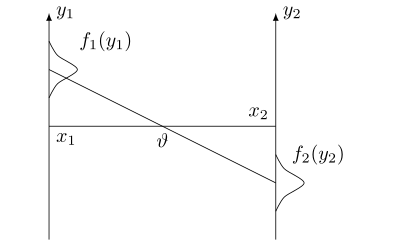

In [3]:
%%tikz -f svg
\draw[-latex] (0,0) -- (0,4) node[right] {$y_1$};
\draw[-latex] (4,0) -- (4,4) node[right] {$y_2$};
\draw (0,2) node[below right] {$x_1$} -- node[below] {$\vartheta$} (4,2) node[above left] {$x_2$};
\draw (0,3) -- (4,1);
\draw plot [smooth] coordinates {(0,3.5) (0.15,3.25) (0.5,3) (0.15,2.75) (0,2.5)};
\draw plot [smooth] coordinates {(4,1.5) (4.15,1.25) (4.5,1) (4.15,0.75) (4,0.5)};
\node at (1,3.5) {$f_1(y_1)$};
\node at (4.75,1.5) {$f_2(y_2)$};

# Joint distribution function
$$
    f_Y(y_1,y_2) = \frac{1}{2 \pi \sigma_1 \sigma_2 \sqrt{1 - \rho^2}} exp \left( -\frac{1}{2(1-\rho^2)} \left[ \left( \frac{y_1-\mu_1}{\sigma_1} \right)^2 -2 \rho \frac{ y_1 - \mu_1 }{\sigma_1}\frac{ y_2 - \mu_2 }{\sigma_2} + \left( \frac{y_2 - \mu_2}{\sigma_2} \right)^2 \right] \right)
$$

In [4]:
def f(y1, y2, m1, m2, sigma1, sigma2, rho):
    factor = 1 / (2 * np.pi * sigma1 * sigma2 * np.sqrt( 1 - rho**2 ))
    factor2 = -1 / ( 2 * (1 - rho**2) ) 
    polynom = ((y1 - m1)/sigma1)**2 - 2 * rho * (y1 - m1) * (y2 - m2) / sigma1 / sigma2 + ((y2 - m2)/sigma2)**2
    return factor * np.exp( factor2 * polynom )

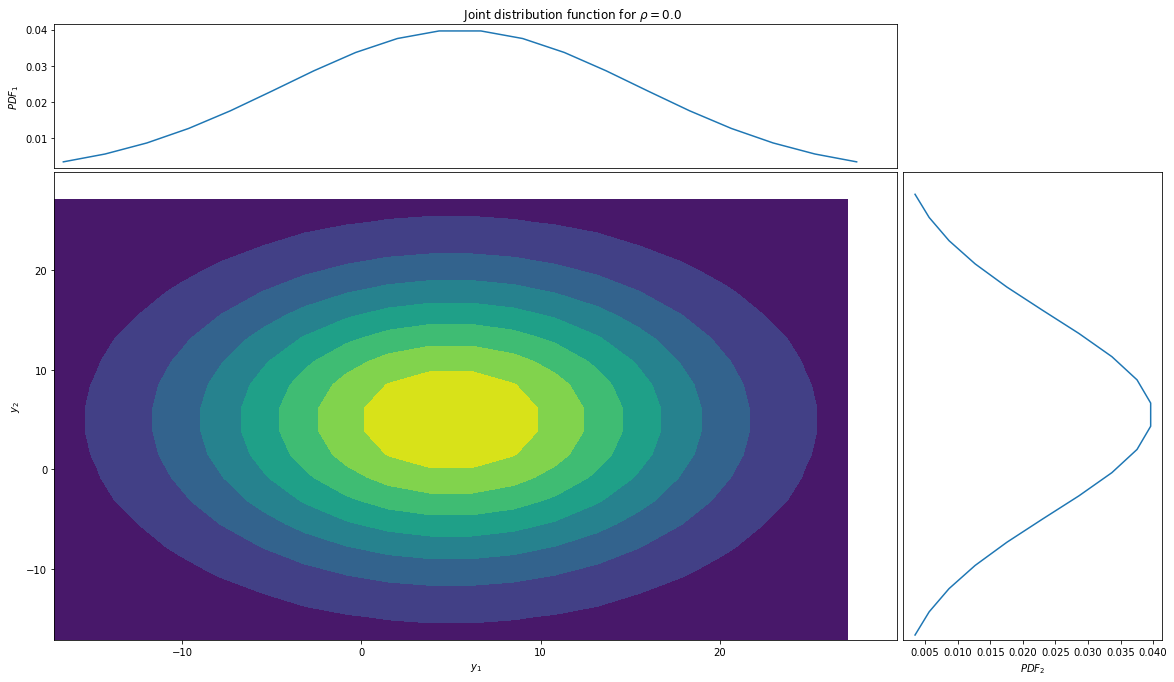

In [5]:
m1 = 5.0
m2 = 5.0
rho = 0.0
sigma1 = 10.0
sigma2 = 10.0
covariance = np.array([
    [sigma1**2, rho*sigma1*sigma2],
    [rho*sigma1*sigma2, sigma1**2]
])

x = np.linspace(m1-7*np.sqrt(sigma1), m1+7*np.sqrt(sigma1), 20)
y = np.linspace(m2-7*np.sqrt(sigma2), m2+7*np.sqrt(sigma2), 20)
xx, yy = np.meshgrid(x, y)

pdf1 = 1/(sigma1 * np.sqrt(2*np.pi)) * np.exp( -0.5 * ((x-m1)/sigma1)**2 )
pdf2 = 1/(sigma2 * np.sqrt(2*np.pi)) * np.exp( -0.5 * ((y-m2)/sigma2)**2 )
res = f(xx, yy, m1, m2, sigma1, sigma2, rho)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(18,10))
fig.suptitle('Joint distribution function for $\\rho=0.0$')

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

c = ax.contourf(x, y ,res, origin='lower')
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')

ax_histx.plot(x+0.5, pdf1)
ax_histx.get_xaxis().set_visible(False)
ax_histx.set_ylabel('$PDF_1$')
ax_histy.plot(pdf2, y+0.5)
ax_histy.get_yaxis().set_visible(False)
ax_histy.set_xlabel('$PDF_2$')

plt.show()

# Level crossing probabilities for edges (1-cells)
\begin{align}
    Prob(\vartheta\text{-crosing}) &= Prob(Y_1 \leq \vartheta, Y_2 > \vartheta) &+ Prob(Y_1 > \vartheta, Y_2 \leq \vartheta) \\
    &= \int\limits_{y_1 \leq \vartheta} ~ \int\limits_{y_2 > \vartheta} f_Y(y_1,y_2) dy_1 dy_2 &+ \int\limits_{y_1 > \vartheta} ~ \int\limits_{y_2 \leq \vartheta} f_Y(y_1,y_2) dy_1 dy_2 \\
    Prob(\vartheta\text{-crosing}) &= 1 \geq Prob(\vartheta\text{-non-crosing})
\end{align}

In [6]:
#@interact(m1=(0.0,10.0),m2=(0.0,10.0),sigma1=(0.0,5.0),sigma2=(0.0,5.0),r=(-0.99,0.99),theta=(0.,20.))
def interact_prob(m1=4.0, m2=6.0, sigma1=1.0, sigma2=1.0, r=0.0, theta=5.0):
    rho = np.linspace(-0.99, 0.99, 50)
    idx_r = np.searchsorted(rho, r)

    y1 = np.linspace(m1-7*np.sqrt(sigma1), m1+7*np.sqrt(sigma1), 40)
    y2 = np.linspace(m2-7*np.sqrt(sigma2), m2+7*np.sqrt(sigma2), 40)
    dy1 = y1[1] - y1[0]
    dy2 = y2[1] - y2[0]
    dy1y2 = dy1 * dy2
    yy1, yy2 = np.meshgrid(y1, y2)
    pdf1 = 1/(sigma1 * np.sqrt(2*np.pi)) * np.exp( -0.5 * ((y1-m1)/sigma1)**2 )
    pdf2 = 1/(sigma2 * np.sqrt(2*np.pi)) * np.exp( -0.5 * ((y2-m2)/sigma2)**2 )
    pdf = np.array([f(yy1, yy2, m1, m2, sigma1, sigma2, r) for r in rho])

    t1 = np.searchsorted(y1, theta)
    t2 = np.searchsorted(y2, theta)
    
    prob = [np.sum(pdf[i,:t1,t2:] * dy1y2) + np.sum(pdf[i,t1:,:t2] * dy1y2) for i in range(rho.shape[0])]
    
    plt.figure(figsize=(18,6))
    plt.plot(rho, prob)
    plt.xlabel('$\\rho$')
    plt.ylabel('P($\\vartheta$-crossing)')
    plt.vlines(r, 0.0, 1.1, colors='r')
    plt.xlim(-1,1)
    plt.ylim(0,1.1)
    plt.vlines(0, 0.0, 1.1, colors='k', linestyles='dotted')
    plt.show()
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    fig = plt.figure(figsize=(18,10))

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    c = ax.contourf(y1, y2 ,pdf[idx_r,...], origin='lower')
    ax.set_xticks(y1[::4])
    ax.set_yticks(y2[::4])
    ax.set_xlim(-3,11)
    ax.set_ylim(-3,11)
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
    
    ax.hlines(theta, y1[0], y1[-1], colors='r', linestyles='dotted')
    ax.vlines(theta, y2[0], y2[-1], colors='r', linestyles='dotted')
    
    rec1 = plt.Rectangle((theta,theta), y1[0] - theta, y2[-1] - theta, facecolor="gray", hatch=r"\\", alpha=0.5 )
    rec2 = plt.Rectangle((theta,theta), y1[-1] - theta, y2[0] - theta, facecolor="gray", hatch=r"\\", alpha=0.5 )
    ax.add_patch(rec1)
    ax.add_patch(rec2)
    

    ax_histx.plot(y1, pdf1)
    ax_histx.get_xaxis().set_visible(False)
    ax_histx.set_ylabel('$PDF_1$')
    ax_histy.plot(pdf2, y2)
    ax_histy.get_yaxis().set_visible(False)
    ax_histy.set_xlabel('$PDF_2$')
    
    #ax_histx.set_ylim(0,0.5)
    #ax_histy.set_xlim(0,0.5)

    plt.show()
    
interactive_plot = interactive(interact_prob, m1=(0.0,10.0),m2=(0.0,10.0),sigma1=(0.0,5.0),sigma2=(0.0,5.0),r=(-0.99,0.99),theta=(0.,20.))
output = interactive_plot.children[-1]
output.layout.height = '2100px'
interactive_plot

interactive(children=(FloatSlider(value=4.0, description='m1', max=10.0), FloatSlider(value=6.0, description='…